# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model
1. Learn how to deploy and use a text model on CAIP


## Introduction


In this notebook, we will implement text models to recognize the probable source (GitHub, TechCrunch, or The New York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [59]:
import os
import warnings

import pandas as pd
from google.cloud import bigquery

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set `PATH` to include the directory containing saved_model_cli
%load_ext tensorboard
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.


Replace the variable values in the cell below:

In [7]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [8]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [9]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,http://mindaverse.com/2008/12/18/save-time-wit...,Using a Virtual Assistant to become more produ...,12
1,https://arstechnica.com/gaming/2024/04/a-touch...,Delta takes flight: Apple-approved Nintendo em...,23
2,https://www.discoursemagazine.com/p/zoning-out...,Zoning Out American Families,22
3,https://twitter.com/winglian/status/1783122644...,Llama3 – 65k Context Window with great recall,23
4,https://github.com/gateweaver/gateweaver,Show HN: I've developed an open-source proxy s...,11
5,https://technicshistory.com/2024/04/25/twiligh...,"Twilight of the Age of Steam, Part 2: Petroleu...",17
6,http://venturebeat.com/2012/05/22/jon-radoff-t...,Game of Thrones Anti-Social Game,12
7,https://petapixel.com/2024/04/18/this-viral-ki...,Viral Kickstarter Telephoto Camera Makes Impos...,26
8,http://news.yahoo.com/software-exec-charged-le...,Silicon Valley Exec Caught Stealing Legos from...,11
9,https://www.threads.net/@moskov/post/C6KW_Odvky0,Dustin Moskovitz says Tesla is the next Enron,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [10]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,186010
1,medium,134593
2,youtube,130417
3,nytimes,85286
4,blogspot,62207
...,...,...
95,nextplatform,3172
96,itworld,3161
97,atlasobscura,3084
98,anandtech,3015


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [11]:
regex = ".*://(.[^/]+)/"


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(
    regex
)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(
    sub_query=sub_query
)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [12]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,onetext yc w23 is hiring a lead ux engineer,github
1,final eurovision predictions from markov chain...,github
2,barber pole progress view for ios,github
3,infinite pixel art canvas on the terminal rus...,github
4,show hn chrome extension for webpage summariz...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [13]:
print(f"The full dataset contains {len(title_dataset)} titles")

The full dataset contains 331242 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [14]:
title_dataset.source.value_counts()

source
github        186010
nytimes        85286
techcrunch     59946
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [15]:
DATADIR = "./data/"

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [16]:
FULL_DATASET_NAME = "titles_full.csv"
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding="utf-8"
)

## Re-usable Embedding Models

In [52]:
import datetime
import os
import shutil

import keras
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Input, Lambda, TextVectorization
from keras.models import Model
from keras.utils import to_categorical
from tensorflow_hub import KerasLayer

# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.18.1


In [18]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [19]:
MODEL_DIR = f"gs://{BUCKET}/text_models"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, TechCrunch, or The New York Times):

In [57]:
ls $DATADIR

titles_full.csv


In [21]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATADIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,the stars of the internet,nytimes
1,n64 recompiled,github
2,a better c assertion library which also prin...,github
3,be-a-magpie is payperpost for twitter,techcrunch
4,show hn open-source meta raybans with 6x of t...,github


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [22]:
titles_df.source.value_counts()

source
github        186010
nytimes        85286
techcrunch     59946
Name: count, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [23]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [24]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [25]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Preparing the train/test splits

Let's split our data into train and test splits:

In [26]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [27]:
sources_train.value_counts()

source
github        176806
nytimes        80988
techcrunch     56885
Name: count, dtype: int64

In [28]:
sources_valid.value_counts()

source
github        9204
nytimes       4298
techcrunch    3061
Name: count, dtype: int64

Now let's create the features and labels we will feed our models with:

In [29]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [30]:
X_train[:3]

array(['the stars of the internet', 'n64  recompiled',
       'a better c   assertion library which also prints a debug message'],
      dtype=object)

In [31]:
Y_train[:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [32]:
# TODO 1
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True
)

2025-08-28 21:24:45.471410: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [33]:
# TODO 1
nnlm_module(
    keras.ops.convert_to_tensor(
        ["The dog is happy to see people in the street."]
    )
)

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [34]:
# TODO 1
SWIVEL = (
    "https:hub_module=b.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
)
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True
)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [35]:
# TODO 1
swivel_module(
    keras.ops.convert_to_tensor(
        ["The dog is happy to see people in the street."]
    )
)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [48]:
# def build_model(hub_module, name):
#     model = Sequential(
#         [
#             hub_module,  # TODO 2
#             Dense(16, activation="relu"),
#             Dense(N_CLASSES, activation="softmax"),
#         ],
#         name=name,
#     )

#     model.compile(
#         optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model


def build_model(hub_module, module_output_dim, name):
    # Define the input layer for raw text strings
    inputs = Input(shape=(), dtype=tf.string, name="text_input")

    # Wrap the hub_module call in a Lambda layer so it can output a KerasTensor
    x = Lambda(
        lambda tensor: hub_module(tensor), output_shape=(module_output_dim,)
    )(inputs)

    # Add a Dense layer
    x = Dense(16, activation="relu")(x)

    # Add the final Dense layer for classification
    outputs = Dense(N_CLASSES, activation="softmax")(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name=name)

    # Compile the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [49]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train,
        Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(patience=3), TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [50]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [53]:
nnlm_model = build_model(
    hub_module=nnlm_module, module_output_dim=50, name="nnlm"
)
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3547 - loss: 1.0999 - val_accuracy: 0.6567 - val_loss: 0.9135
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6743 - loss: 0.8568 - val_accuracy: 0.7008 - val_loss: 0.7407
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7138 - loss: 0.7066 - val_accuracy: 0.7321 - val_loss: 0.6565
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7413 - loss: 0.6337 - val_accuracy: 0.7480 - val_loss: 0.6158
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7558 - loss: 0.5980 - val_accuracy: 0.7543 - val_loss: 0.5969
Epoch 6/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7615 - loss: 0.5812

2025-08-28 21:53:10.086637: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7617 - loss: 0.5808 - val_accuracy: 0.7564 - val_loss: 0.5879
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7649 - loss: 0.5723 - val_accuracy: 0.7561 - val_loss: 0.5832
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7665 - loss: 0.5676 - val_accuracy: 0.7575 - val_loss: 0.5803
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7676 - loss: 0.5645 - val_accuracy: 0.7589 - val_loss: 0.5781
Epoch 10/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7685 - loss: 0.5621

2025-08-28 21:53:19.059843: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7685 - loss: 0.5621 - val_accuracy: 0.7593 - val_loss: 0.5762
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7694 - loss: 0.5600 - val_accuracy: 0.7598 - val_loss: 0.5745
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7703 - loss: 0.5581 - val_accuracy: 0.7607 - val_loss: 0.5727
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7707 - loss: 0.5563 - val_accuracy: 0.7614 - val_loss: 0.5710
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7714 - loss: 0.5546 - val_accuracy: 0.7624 - val_loss: 0.5693
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7722 - loss: 0.5529 - val_accuracy: 0.7636 - val_loss: 0.5675
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7731 - loss: 0.5512 - val_accuracy: 0.7641 - val_loss: 0.5658
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7738 - loss: 0.5497 - val_accuracy: 0.7651 

2025-08-28 21:53:48.353368: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7809 - loss: 0.5349 - val_accuracy: 0.7720 - val_loss: 0.5497
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7815 - loss: 0.5338 - val_accuracy: 0.7721 - val_loss: 0.5487
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7819 - loss: 0.5328 - val_accuracy: 0.7724 - val_loss: 0.5478
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7823 - loss: 0.5319 - val_accuracy: 0.7729 - val_loss: 0.5469
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7830 - loss: 0.5310 - val_accuracy: 0.7730 - val_loss: 0.5461
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7835 - loss: 0.5302 - val_accuracy: 0.7730 - val_loss: 0.5452
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7839 - loss: 0.5294 - val_accuracy: 0.7732 - val_loss: 0.5444
Epoch 35/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7863 - loss: 0.5243

2025-08-28 21:53:59.117888: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7842 - loss: 0.5286 - val_accuracy: 0.7733 - val_loss: 0.5436
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7843 - loss: 0.5279 - val_accuracy: 0.7735 - val_loss: 0.5428
Epoch 37/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7846 - loss: 0.5272 - val_accuracy: 0.7735 - val_loss: 0.5420
Epoch 38/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7848 - loss: 0.5265 - val_accuracy: 0.7737 - val_loss: 0.5413
Epoch 39/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7850 - loss: 0.5258 - val_accuracy: 0.7739 - val_loss: 0.5406
Epoch 40/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7853 - loss: 0.5252 - val_accuracy: 0.7740 - val_loss: 0.5400
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7856 - loss: 0.5246 - val_accuracy: 0.7739 - val_loss: 0.5394
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7860 - loss: 0.5240 - val_accuracy: 0.7748 

2025-08-28 21:54:19.715967: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7868 - loss: 0.5213 - val_accuracy: 0.7752 - val_loss: 0.5364
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7872 - loss: 0.5208 - val_accuracy: 0.7755 - val_loss: 0.5360
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7875 - loss: 0.5203 - val_accuracy: 0.7762 - val_loss: 0.5355
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7877 - loss: 0.5198 - val_accuracy: 0.7763 - val_loss: 0.5351
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7877 - loss: 0.5193 - val_accuracy: 0.7766 - val_loss: 0.5346
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7881 - loss: 0.5188 - val_accuracy: 0.7779 - val_loss: 0.5341
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7882 - loss: 0.5183 - val_accuracy: 0.7780 - val_loss: 0.5336
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7883 - loss: 0.5178 - val_accuracy: 0.7785 

2025-08-28 21:54:47.721717: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7897 - loss: 0.5136 - val_accuracy: 0.7810 - val_loss: 0.5295
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7901 - loss: 0.5131 - val_accuracy: 0.7810 - val_loss: 0.5290
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7903 - loss: 0.5127 - val_accuracy: 0.7816 - val_loss: 0.5286
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7904 - loss: 0.5123 - val_accuracy: 0.7820 - val_loss: 0.5282
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7906 - loss: 0.5119 - val_accuracy: 0.7818 - val_loss: 0.5278
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7908 - loss: 0.5115 - val_accuracy: 0.7823 - val_loss: 0.5275
Epoch 68/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7909 - loss: 0.5111

2025-08-28 21:54:58.028536: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7909 - loss: 0.5111 - val_accuracy: 0.7828 - val_loss: 0.5271
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7910 - loss: 0.5108 - val_accuracy: 0.7829 - val_loss: 0.5267
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7911 - loss: 0.5104 - val_accuracy: 0.7828 - val_loss: 0.5264
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7912 - loss: 0.5101 - val_accuracy: 0.7832 - val_loss: 0.5261
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7914 - loss: 0.5098 - val_accuracy: 0.7834 - val_loss: 0.5258
Epoch 73/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7918 - loss: 0.5095

2025-08-28 21:55:08.586300: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7917 - loss: 0.5095 - val_accuracy: 0.7836 - val_loss: 0.5256
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7919 - loss: 0.5093 - val_accuracy: 0.7837 - val_loss: 0.5253
Epoch 75/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7923 - loss: 0.5090 - val_accuracy: 0.7840 - val_loss: 0.5251
Epoch 76/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7924 - loss: 0.5088 - val_accuracy: 0.7838 - val_loss: 0.5248
Epoch 77/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7924 - loss: 0.5085 - val_accuracy: 0.7841 - val_loss: 0.5246
Epoch 78/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7926 - loss: 0.5083 - val_accuracy: 0.7844 - val_loss: 0.5244
Epoch 79/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7927 - loss: 0.5081 - val_accuracy: 0.7845 - val_loss: 0.5242
Epoch 80/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7955 - loss: 0.5037

2025-08-28 21:55:19.752591: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7929 - loss: 0.5079 - val_accuracy: 0.7849 - val_loss: 0.5239
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7932 - loss: 0.5077 - val_accuracy: 0.7851 - val_loss: 0.5237
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7934 - loss: 0.5075 - val_accuracy: 0.7852 - val_loss: 0.5235
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7934 - loss: 0.5073 - val_accuracy: 0.7850 - val_loss: 0.5234
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7933 - loss: 0.5071 - val_accuracy: 0.7849 - val_loss: 0.5232
Epoch 85/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7963 - loss: 0.5028

2025-08-28 21:55:28.818616: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7936 - loss: 0.5069 - val_accuracy: 0.7848 - val_loss: 0.5230
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7936 - loss: 0.5067 - val_accuracy: 0.7846 - val_loss: 0.5228
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7936 - loss: 0.5065 - val_accuracy: 0.7847 - val_loss: 0.5226
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7936 - loss: 0.5064 - val_accuracy: 0.7849 - val_loss: 0.5225
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7937 - loss: 0.5062 - val_accuracy: 0.7852 - val_loss: 0.5223
Epoch 90/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7937 - loss: 0.5060

2025-08-28 21:55:39.042871: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/nnlm/validation/events.out.tfevents.1756417978.asl-dev.160322.1.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7937 - loss: 0.5060 - val_accuracy: 0.7855 - val_loss: 0.5221
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7936 - loss: 0.5059 - val_accuracy: 0.7858 - val_loss: 0.5220
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7937 - loss: 0.5057 - val_accuracy: 0.7859 - val_loss: 0.5218
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7936 - loss: 0.5055 - val_accuracy: 0.7861 - val_loss: 0.5217
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7938 - loss: 0.5054 - val_accuracy: 0.7856 - val_loss: 0.5215
Epoch 95/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7938 - loss: 0.5052 - val_accuracy: 0.7853 - val_loss: 0.5214
Epoch 96/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7937 - loss: 0.5051 - val_accuracy: 0.7851 - val_loss: 0.5212
Epoch 97/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7938 - loss: 0.5050 - val_accuracy: 0.7851 

<Axes: >

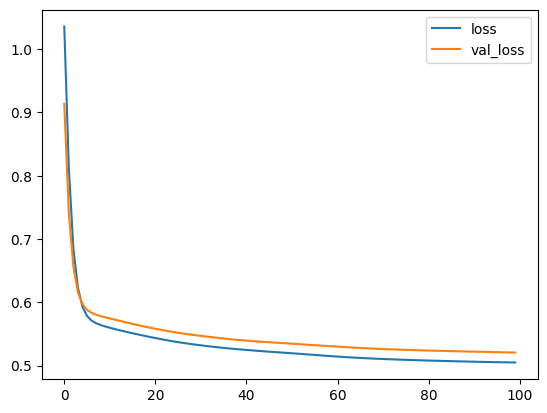

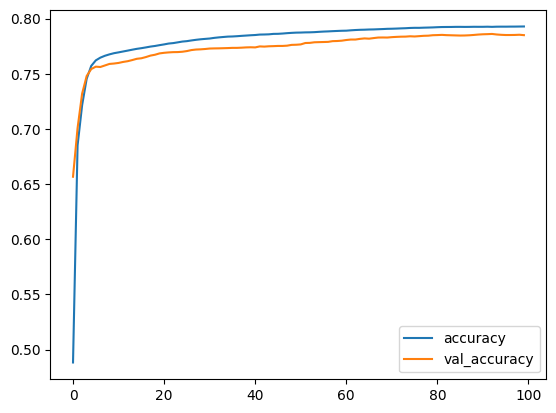

In [54]:
history = nnlm_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

## Training Swivel

In [55]:
swivel_model = build_model(
    hub_module=swivel_module, module_output_dim=20, name="swivel"
)

In [56]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2969 - loss: 1.2824 - val_accuracy: 0.5734 - val_loss: 0.9548
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5942 - loss: 0.9209 - val_accuracy: 0.6199 - val_loss: 0.8673
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6344 - loss: 0.8481 - val_accuracy: 0.6420 - val_loss: 0.8285
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6534 - loss: 0.8116 - val_accuracy: 0.6533 - val_loss: 0.8057
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6650 - loss: 0.7895 - val_accuracy: 0.6607 - val_loss: 0.7919
Epoch 6/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6715 - loss: 0.7746

2025-08-28 21:56:08.972951: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6714 - loss: 0.7761 - val_accuracy: 0.6652 - val_loss: 0.7829
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6756 - loss: 0.7674 - val_accuracy: 0.6685 - val_loss: 0.7766
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6786 - loss: 0.7612 - val_accuracy: 0.6701 - val_loss: 0.7716
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6808 - loss: 0.7566 - val_accuracy: 0.6723 - val_loss: 0.7675
Epoch 10/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6825 - loss: 0.7526

2025-08-28 21:56:17.829186: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6825 - loss: 0.7526 - val_accuracy: 0.6729 - val_loss: 0.7639
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6838 - loss: 0.7490 - val_accuracy: 0.6760 - val_loss: 0.7606
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6851 - loss: 0.7457 - val_accuracy: 0.6784 - val_loss: 0.7575
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6868 - loss: 0.7427 - val_accuracy: 0.6799 - val_loss: 0.7545
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6882 - loss: 0.7398 - val_accuracy: 0.6799 - val_loss: 0.7517
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6895 - loss: 0.7371 - val_accuracy: 0.6825 - val_loss: 0.7490
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6908 - loss: 0.7345 - val_accuracy: 0.6836 - val_loss: 0.7464
Epoch 17/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6927 - loss: 0.7274

2025-08-28 21:56:30.316303: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6918 - loss: 0.7322 - val_accuracy: 0.6846 - val_loss: 0.7440
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6929 - loss: 0.7301 - val_accuracy: 0.6860 - val_loss: 0.7418
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6938 - loss: 0.7283 - val_accuracy: 0.6877 - val_loss: 0.7399
Epoch 20/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6944 - loss: 0.7267 - val_accuracy: 0.6885 - val_loss: 0.7382
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6953 - loss: 0.7253 - val_accuracy: 0.6895 - val_loss: 0.7367
Epoch 22/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6970 - loss: 0.7187

2025-08-28 21:56:39.369475: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6956 - loss: 0.7240 - val_accuracy: 0.6892 - val_loss: 0.7354
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6961 - loss: 0.7228 - val_accuracy: 0.6895 - val_loss: 0.7341
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6965 - loss: 0.7217 - val_accuracy: 0.6898 - val_loss: 0.7330
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6972 - loss: 0.7206 - val_accuracy: 0.6902 - val_loss: 0.7319
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6977 - loss: 0.7197 - val_accuracy: 0.6903 - val_loss: 0.7309
Epoch 27/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6980 - loss: 0.7187

2025-08-28 21:56:49.877339: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6979 - loss: 0.7188 - val_accuracy: 0.6905 - val_loss: 0.7298
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6986 - loss: 0.7179 - val_accuracy: 0.6908 - val_loss: 0.7289
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6987 - loss: 0.7171 - val_accuracy: 0.6908 - val_loss: 0.7280
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6991 - loss: 0.7163 - val_accuracy: 0.6911 - val_loss: 0.7272
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6994 - loss: 0.7155 - val_accuracy: 0.6915 - val_loss: 0.7264
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6996 - loss: 0.7148 - val_accuracy: 0.6915 - val_loss: 0.7257
Epoch 33/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6999 - loss: 0.7140

2025-08-28 21:56:59.995718: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6999 - loss: 0.7141 - val_accuracy: 0.6924 - val_loss: 0.7250
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7001 - loss: 0.7133 - val_accuracy: 0.6931 - val_loss: 0.7243
Epoch 35/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7004 - loss: 0.7127 - val_accuracy: 0.6940 - val_loss: 0.7236
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7009 - loss: 0.7120 - val_accuracy: 0.6946 - val_loss: 0.7230
Epoch 37/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7015 - loss: 0.7114 - val_accuracy: 0.6946 - val_loss: 0.7224
Epoch 38/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7018 - loss: 0.7107

2025-08-28 21:57:09.315850: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7018 - loss: 0.7108 - val_accuracy: 0.6946 - val_loss: 0.7218
Epoch 39/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7023 - loss: 0.7102 - val_accuracy: 0.6948 - val_loss: 0.7213
Epoch 40/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7024 - loss: 0.7096 - val_accuracy: 0.6950 - val_loss: 0.7208
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7028 - loss: 0.7091 - val_accuracy: 0.6950 - val_loss: 0.7203
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7030 - loss: 0.7086 - val_accuracy: 0.6953 - val_loss: 0.7199
Epoch 43/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7064 - loss: 0.7031

2025-08-28 21:57:17.336391: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7034 - loss: 0.7081 - val_accuracy: 0.6953 - val_loss: 0.7195
Epoch 44/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7063 - loss: 0.7027

2025-08-28 21:57:20.483347: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7036 - loss: 0.7077 - val_accuracy: 0.6952 - val_loss: 0.7191
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7039 - loss: 0.7072 - val_accuracy: 0.6952 - val_loss: 0.7188
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7042 - loss: 0.7068 - val_accuracy: 0.6950 - val_loss: 0.7184
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7044 - loss: 0.7064 - val_accuracy: 0.6952 - val_loss: 0.7181
Epoch 48/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7045 - loss: 0.7060

2025-08-28 21:57:30.551323: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7045 - loss: 0.7061 - val_accuracy: 0.6950 - val_loss: 0.7177
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7047 - loss: 0.7057 - val_accuracy: 0.6953 - val_loss: 0.7174
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7050 - loss: 0.7054 - val_accuracy: 0.6954 - val_loss: 0.7171
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7052 - loss: 0.7051 - val_accuracy: 0.6955 - val_loss: 0.7168
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7053 - loss: 0.7048 - val_accuracy: 0.6963 - val_loss: 0.7165
Epoch 53/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7054 - loss: 0.7045

2025-08-28 21:57:39.744678: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7054 - loss: 0.7045 - val_accuracy: 0.6965 - val_loss: 0.7162
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7055 - loss: 0.7043 - val_accuracy: 0.6964 - val_loss: 0.7160
Epoch 55/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7057 - loss: 0.7040 - val_accuracy: 0.6966 - val_loss: 0.7157
Epoch 56/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7058 - loss: 0.7038 - val_accuracy: 0.6969 - val_loss: 0.7155
Epoch 57/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7057 - loss: 0.7036 - val_accuracy: 0.6967 - val_loss: 0.7152
Epoch 58/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7058 - loss: 0.7034 - val_accuracy: 0.6966 - val_loss: 0.7150
Epoch 59/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7058 - loss: 0.7032 - val_accuracy: 0.6964 - val_loss: 0.7148
Epoch 60/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7060 - loss: 0.7030 - val_accuracy: 0.6959 

2025-08-28 21:58:09.216924: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7064 - loss: 0.7016 - val_accuracy: 0.6967 - val_loss: 0.7134
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7065 - loss: 0.7015 - val_accuracy: 0.6969 - val_loss: 0.7132
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7064 - loss: 0.7014 - val_accuracy: 0.6967 - val_loss: 0.7131
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7066 - loss: 0.7012 - val_accuracy: 0.6967 - val_loss: 0.7130
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7067 - loss: 0.7011 - val_accuracy: 0.6967 - val_loss: 0.7129
Epoch 75/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7087 - loss: 0.6966

2025-08-28 21:58:19.713679: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7067 - loss: 0.7010 - val_accuracy: 0.6971 - val_loss: 0.7128
Epoch 76/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7067 - loss: 0.7009 - val_accuracy: 0.6972 - val_loss: 0.7127
Epoch 77/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7068 - loss: 0.7008 - val_accuracy: 0.6973 - val_loss: 0.7126
Epoch 78/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7086 - loss: 0.6963

2025-08-28 21:58:25.606484: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7068 - loss: 0.7007 - val_accuracy: 0.6978 - val_loss: 0.7125
Epoch 79/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7069 - loss: 0.7006 - val_accuracy: 0.6977 - val_loss: 0.7123
Epoch 80/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7068 - loss: 0.7006 - val_accuracy: 0.6981 - val_loss: 0.7122
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7069 - loss: 0.7005 - val_accuracy: 0.6982 - val_loss: 0.7121
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7070 - loss: 0.7004 - val_accuracy: 0.6982 - val_loss: 0.7120
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7072 - loss: 0.7003 - val_accuracy: 0.6984 - val_loss: 0.7119
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7072 - loss: 0.7002 - val_accuracy: 0.6982 - val_loss: 0.7119
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7072 - loss: 0.7001 - val_accuracy: 0.6980 

2025-08-28 21:58:40.950374: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7073 - loss: 0.7001 - val_accuracy: 0.6979 - val_loss: 0.7117
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7074 - loss: 0.7000 - val_accuracy: 0.6981 - val_loss: 0.7117
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7074 - loss: 0.6999 - val_accuracy: 0.6983 - val_loss: 0.7116
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7075 - loss: 0.6998 - val_accuracy: 0.6981 - val_loss: 0.7115
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7075 - loss: 0.6997 - val_accuracy: 0.6985 - val_loss: 0.7114
Epoch 91/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7076 - loss: 0.6996

2025-08-28 21:58:50.021759: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7075 - loss: 0.6997 - val_accuracy: 0.6984 - val_loss: 0.7113
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7076 - loss: 0.6996 - val_accuracy: 0.6987 - val_loss: 0.7113
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7076 - loss: 0.6995 - val_accuracy: 0.6990 - val_loss: 0.7112
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7077 - loss: 0.6994 - val_accuracy: 0.6990 - val_loss: 0.7111
Epoch 95/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7079 - loss: 0.6994 - val_accuracy: 0.6986 - val_loss: 0.7111
Epoch 96/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7079 - loss: 0.6993 - val_accuracy: 0.6989 - val_loss: 0.7110
Epoch 97/100
 9/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7101 - loss: 0.6951

2025-08-28 21:58:59.009759: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7079 - loss: 0.6992 - val_accuracy: 0.6992 - val_loss: 0.7109
Epoch 98/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7078 - loss: 0.6992 - val_accuracy: 0.6993 - val_loss: 0.7108
Epoch 99/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7080 - loss: 0.6991 - val_accuracy: 0.6993 - val_loss: 0.7107
Epoch 100/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7080 - loss: 0.6990 - val_accuracy: 0.6991 - val_loss: 0.7106


2025-08-28 21:59:08.201893: I external/local_tsl/tsl/platform/cloud/gcs_file_system.cc:632] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://sanjana-sandbox-012024/text_models/swivel/validation/events.out.tfevents.1756418159.asl-dev.160322.3.v2


<Axes: >

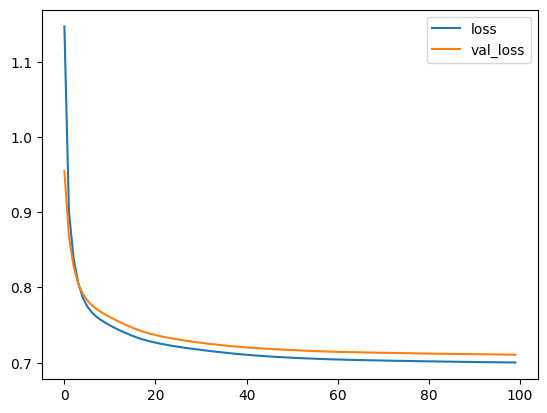

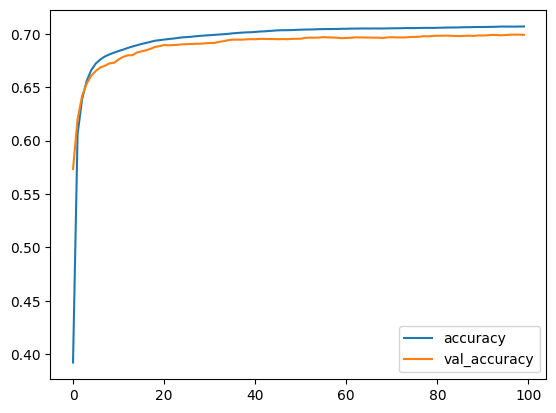

In [66]:
history = swivel_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

## Comparing the models

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

At last, let's compare all the models we have trained at once using TensorBoard in order
to choose the one that overfits the less for the same performance level.

Run the command to launch TensorBoard, and you'll be able to compare both the models in a more interactive way.

In [61]:
%tensorboard --logdir $MODEL_DIR --port 8008

## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [ ]:
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)


SAVEDMODEL_PATH = os.path.join(EXPORT_PATH, "savedmodel")

In [65]:
# Export the model for inference using model.export()
OUTPUT_DIR = "./savedmodels_vertex"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)
SAVED_MODEL_PATH = os.path.join(EXPORT_PATH, "savedmodel")
# shutil.rmtree(SAVED_MODEL_PATH, ignore_errors=True)
swivel_model.export(SAVED_MODEL_PATH)

# Define variables for deployment
MODEL_DISPLAY_NAME = f"title_model_{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"swivel_{TIMESTAMP}"
IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-18:latest"
ARTIFACT_DIRECTORY = f"gs://{BUCKET}/{MODEL_DISPLAY_NAME}/"
os.environ["SAVED_MODEL_PATH"] = SAVED_MODEL_PATH

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper___call___196429'
	Captured Tensor = <ResourceHandle(name="hash_table_<google3.third_party.tensorflow.python.training.tracking.tracking.TrackableAsset object at 0x7faef27d6ed0>_-2_-1_load_170_259", device="/job:localhost/replica:0/task:0/device:CPU:0", container="localhost", type="tensorflow::lookup::LookupInterface", dtype and shapes : "[  ]")>
	Trackable referencing this tensor = <tensorflow.python.trackable.resource.RestoredResource object at 0x7fb57d769a50>
	Internal Tensor = Tensor("196413:0", shape=(), dtype=resource)

Then we can deploy the model using the gcloud CLI as before:

In [ ]:
%%bash

# TODO 5

TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=title_model_$TIMESTAMP
ENDPOINT_DISPLAYNAME=swivel_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
ARTIFACT_DIRECTORY=gs://${BUCKET}/${MODEL_DISPLAYNAME}/
echo $ARTIFACT_DIRECTORY

gsutil cp -r ${EXPORT_PATH}/* ${ARTIFACT_DIRECTORY}

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$ARTIFACT_DIRECTORY \
    --format="value(model)")

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"

# Deployment
DEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2
MIN_REPLICA_COUNT=1
MAX_REPLICA_COUNT=3

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=$MIN_REPLICA_COUNT \
  --max-replica-count=$MAX_REPLICA_COUNT \
  --traffic-split=0=100

In [ ]:
import datetime
import os

from google.cloud import aiplatform

# --- Configuration (replace with your values) ---
# These are often derived from your environment, similar to the notebook.
# PROJECT = os.environ.get("PROJECT")
# BUCKET = os.environ.get("BUCKET")
# REGION = os.environ.get("REGION")

# Local path to your exported model directory
EXPORT_PATH = "./savedmodels_vertex/swivel"

# --- Initialize Vertex AI SDK ---
aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

# --- 1. Define Names and URIs ---
# This section corresponds to the variable definitions in your bash script.
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_DISPLAY_NAME = f"title_model_{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"swivel_{TIMESTAMP}"
IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
ARTIFACT_DIRECTORY = f"gs://{BUCKET}/{MODEL_DISPLAY_NAME}/"

print(f"Using artifact directory: {ARTIFACT_DIRECTORY}")

# Note: The original script uses `gsutil` to copy model files to GCS.
# The `aiplatform.Model.upload` function can upload from a local path,
# but it's often better to explicitly upload to a permanent GCS location first.
# For this script, we will assume the artifacts need to be in GCS as specified
# by ARTIFACT_DIRECTORY before calling upload.
print("Please ensure your model files are copied to the artifact directory.")
print(f"You can use: gsutil cp -r {EXPORT_PATH}/* {ARTIFACT_DIRECTORY}")


# --- 2. Upload the Model ---
# This replaces the `gcloud ai models upload` command.
print(f"Uploading model: {MODEL_DISPLAY_NAME}")
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=IMAGE_URI,
    artifact_uri=ARTIFACT_DIRECTORY,
)

print(f"Model uploaded. Resource name: {model.resource_name}")


# --- 3. Create an Endpoint ---
# This replaces the `gcloud ai endpoints create` command.
print(f"Creating endpoint: {ENDPOINT_DISPLAY_NAME}")
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

print(f"Endpoint created. Resource name: {endpoint.resource_name}")

# --- 4. Deploy the Model to the Endpoint ---
# This replaces the `gcloud ai endpoints deploy-model` command.
DEPLOYED_MODEL_DISPLAY_NAME = f"{MODEL_DISPLAY_NAME}_deployment"
MACHINE_TYPE = "n1-standard-2"
MIN_REPLICA_COUNT = 1
MAX_REPLICA_COUNT = 3

print(f"Deploying model to endpoint...")
endpoint.deploy(
    model=model,
    deployed_model_display_name=DEPLOYED_MODEL_DISPLAY_NAME,
    machine_type=MACHINE_TYPE,
    min_replica_count=MIN_REPLICA_COUNT,
    max_replica_count=MAX_REPLICA_COUNT,
    traffic_split={"0": 100},
)

print("Deployment complete.")
print(f"Endpoint resource name for predictions: {endpoint.resource_name}")

Note the `ENDPOINT_RESOURCENAME` above as you'll need it below for the prediction.

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [ ]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

Let's go ahead and hit our model:

In [ ]:
%%writefile input.json
{
    "instances": [
        {"keras_layer_1_input": "hello"}
    ]
}

Insert below the `ENDPOINT_RESOURCENAME` from the deployment code above.

In [ ]:
%%bash
ENDPOINT_RESOURCENAME= #TODO: insert the ENDPOINT_RESOURCENAME here from above
gcloud ai endpoints predict $ENDPOINT_RESOURCENAME \
  --region $REGION \
  --json-request input.json

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License